In [ ]:
import numpy as np 
import pandas as pd 
from pandas import DataFrame
from datetime import datetime 

In [1]:
careplans = pd.read_csv('/kaggle/input/trainset/train/careplans.csv')
immunizations = pd.read_csv('/kaggle/input/trainset/train/immunizations.csv')
patients = pd.read_csv('/kaggle/input/trainset/train/patients.csv')
observations = pd.read_csv('/kaggle/input/trainset/train/observations.csv')
encounters = pd.read_csv('/kaggle/input/trainset/train/encounters.csv')
conditions = pd.read_csv('/kaggle/input/trainset/train/conditions.csv')
patients = pd.read_csv('/kaggle/input/trainset/train/patients.csv')
procedures = pd.read_csv('/kaggle/input/trainset/train/procedures.csv')
medications = pd.read_csv('/kaggle/input/trainset/train/medications.csv')  

NameError: name 'pd' is not defined

Identify positive covid-19 patients using the given code, create column '*COVID_STAT*'. 

In [13]:
neg_covid_id = observations[(observations.CODE == '94531-1')
                                & (observations.VALUE == 'Not detected (qualifier value)')].PATIENT.unique()
pos_covid_id = conditions[(conditions.CODE == 840539006)].PATIENT.unique()
pos_covid_id = DataFrame(pos_covid_id, columns = ['Id'])
neg_covid_id = DataFrame(neg_covid_id, columns = ['Id'])
patients['COVID_STAT'] = 1  
patients.loc[patients.Id.isin(pos_covid_id.Id),'COVID_STAT'] = 0

Identify patients who died in 2020, because they are likely to died as a result of covid-19. 

In [14]:
# death after 2020 . 
patients['DEATHDATE']= patients['DEATHDATE'].astype('datetime64[ns]')
patients['BIRTHDATE']= patients['BIRTHDATE'].astype('datetime64[ns]')
patients['Decease_2020'] = 0
patients.loc[patients.DEATHDATE.dt.year == 2020,'Decease_2020'] = 1 
patients.loc[patients.DEATHDATE.dt.year < 2020,'Decease_2020'] = 0.1

Identify the decease from covid-19 and patients who still alive in order to create the target values. 

In [15]:
patients['Target_AD'] = 1.0                                   
DEATH_patients = DataFrame(patients[~(patients.DEATHDATE.isna())])
pos_covid_id.set_index('Id', inplace=True)
DEATH_patients.set_index('Id', inplace=True)
idx1 = pd.Index(DEATH_patients.index)
idx2 = pd.Index(pos_covid_id.index)
a = idx1.intersection(idx2)
deceased_covid19_ids = DataFrame(a)
patients.loc[patients.Id.isin(deceased_covid19_ids.Id),'Target_AD'] = 0.0
patients = pd.merge(patients,
                    deceased_covid19_ids,
                    how = 'left',
                    on = 'Id')

Compute the age of each patients, include those who has died.  

In [ ]:
patients['DEATHDATE'] = patients['DEATHDATE'].fillna(np.datetime64('NOW'))
patients['AGE'] = (patients['DEATHDATE'] - patients['BIRTHDATE'].astype('M8[D]')).astype('timedelta64[Y]').astype(float)

Compute the total num of hospitalized days for each patients.

In [16]:
from datetime import datetime
encounters['START']= encounters['START'].astype('datetime64[ns]')
encounters['STOP']= encounters['STOP'].astype('datetime64[ns]')
total_hospitalized_days = DataFrame(encounters[['PATIENT','START','STOP']])
total_hospitalized_days['NUM_DAYS_HOPS'] = (total_hospitalized_days['STOP']-total_hospitalized_days['START']).astype('timedelta64[D]').astype(float)
total_hospitalized_days = total_hospitalized_days.groupby(['PATIENT']).sum()
patients = pd.merge(patients,
                   total_hospitalized_days,
                   how = 'left',
                   left_on = 'Id',
                   right_on= 'PATIENT')
patients['NUM_DAYS_HOPS'] = patients['NUM_DAYS_HOPS'].fillna(0.0)

Compute the num of hospitalized days as a result of covid-19 for each patients.

In [17]:
# identify covid-19 hospitalized patients.
hospitalized_ids = encounters[(encounters.REASONCODE == 840539006)
                         & (encounters.CODE ==1505002)].PATIENT.unique()
hospitalized_ids = DataFrame(hospitalized_ids,columns=['Id'])  # 20402 rows × 1 columns
covid_hospitalized_days = DataFrame(encounters[encounters.PATIENT.isin(hospitalized_ids.Id)])
## compute num of days.
covid_hospitalized_days = covid_hospitalized_days[['PATIENT','START','STOP','DESCRIPTION','ENCOUNTERCLASS']]
covid_hospitalized_days['START']= covid_hospitalized_days['START'].astype('datetime64[ns]')
covid_hospitalized_days['STOP']= covid_hospitalized_days['STOP'].astype('datetime64[ns]')
covid_hospitalized_days['Covid_NUM_DAYS_HOPS'] = (covid_hospitalized_days['STOP']-covid_hospitalized_days['START']).astype('timedelta64[D]').astype(float)
covid_hospitalized_days = covid_hospitalized_days[covid_hospitalized_days.START.dt.year == 2020]
covid_hospitalized_days = covid_hospitalized_days[covid_hospitalized_days.Covid_NUM_DAYS_HOPS != 0.0]
covid_hospitalized_days = covid_hospitalized_days.groupby(['PATIENT']).sum()
patients = pd.merge(patients,
                   covid_hospitalized_days,
                   how = 'left',
                   left_on = 'Id',
                   right_on= 'PATIENT')
patients['Covid_NUM_DAYS_HOPS'] = patients['Covid_NUM_DAYS_HOPS'].fillna(0.0)

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,...,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,COVID_STAT,Decease_2020,Target_AD,AGE,NUM_DAYS_HOPS,Covid_NUM_DAYS_HOPS
0,93fa6213-73a1-4cce-b408-9986a4145801,1989-09-05,2001-12-04 00:00:00,999-87-8276,NaN,NaN,NaN,Roland928,Wolff180,NaN,...,42.398277,-71.289383,6520.55,0.00,1,0.1,1.0,12.0,0.0,0.0
1,53bbfa41-5cab-422e-a8a7-8fa3ae55ed71,1997-09-25,2020-07-03 07:22:55,999-96-1808,S99962046,X54333499X,Mr.,Jorge203,Chavarría957,NaN,...,42.691016,-71.275475,545777.93,3282.24,1,0.0,1.0,22.0,0.0,0.0
2,30fb496e-b8d3-4d36-8e50-86acb3d1a223,1981-09-11,2020-07-03 07:22:55,999-89-5604,S99970660,X20079551X,Mr.,Octavio643,Schneider199,NaN,...,42.174484,-72.784777,1039005.83,2796.44,1,0.0,1.0,38.0,0.0,0.0


Compute num of days in icu.

In [18]:
icu_id = encounters[(encounters.CODE == 305351004)
                   &(encounters.PATIENT.isin(pos_covid_id.index))].PATIENT
covid_icu_days = DataFrame(encounters[encounters.PATIENT.isin(icu_id)])
covid_icu_days = covid_icu_days[['PATIENT','START','STOP','DESCRIPTION','ENCOUNTERCLASS']]
covid_icu_days['START']= covid_icu_days['START'].astype('datetime64[ns]')
covid_icu_days['STOP']= covid_icu_days['STOP'].astype('datetime64[ns]')
covid_icu_days['Covid_NUM_DAYS_ICU'] = (covid_icu_days['STOP']-covid_icu_days['START']).astype('timedelta64[D]').astype(float)
covid_icu_days = covid_icu_days[covid_icu_days.START.dt.year == 2020]
covid_icu_days = covid_icu_days.groupby(['PATIENT']).sum()
covid_icu_days
patients = pd.merge(patients,
                   covid_icu_days,
                   how = 'left',
                   left_on = 'Id',
                   right_on = 'PATIENT')
patients['Covid_NUM_DAYS_ICU'] = patients['Covid_NUM_DAYS_ICU'].fillna(0.0)

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,...,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,COVID_STAT,Decease_2020,Target_AD,AGE,NUM_DAYS_HOPS,Covid_NUM_DAYS_HOPS,Covid_NUM_DAYS_ICU
0,93fa6213-73a1-4cce-b408-9986a4145801,1989-09-05,2001-12-04 00:00:00,999-87-8276,NaN,NaN,NaN,Roland928,Wolff180,NaN,...,-71.289383,6520.55,0.00,1,0.1,1.0,12.0,0.0,0.0,0.0
1,53bbfa41-5cab-422e-a8a7-8fa3ae55ed71,1997-09-25,2020-07-03 07:22:55,999-96-1808,S99962046,X54333499X,Mr.,Jorge203,Chavarría957,NaN,...,-71.275475,545777.93,3282.24,1,0.0,1.0,22.0,0.0,0.0,0.0
2,30fb496e-b8d3-4d36-8e50-86acb3d1a223,1981-09-11,2020-07-03 07:22:55,999-89-5604,S99970660,X20079551X,Mr.,Octavio643,Schneider199,NaN,...,-72.784777,1039005.83,2796.44,1,0.0,1.0,38.0,0.0,0.0,0.0


**Find: covid-19 Icu patients is a subset of covid-19 hospitalized patients.** 

In [ ]:
covid_hospitalized_days = covid_hospitalized_days.groupby(['PATIENT']).sum()
print(covid_hospitalized_days.shape)
a = pd.merge(covid_icu_days,
                   covid_hospitalized_days,
                   how = 'outer',
                   on = 'PATIENT')
print(a.shape)

Identify controlled ventilation status for each patients.

In [19]:
vent_ids = procedures[(procedures.CODE == 26763009) 
                            & (procedures.PATIENT.isin(pos_covid_id.index))].PATIENT
patients['VENT'] = 0
patients.loc[patients.Id.isin(vent_ids),'VENT'] = 1
vent_procedures = procedures[procedures.PATIENT.isin(vent_ids)]  

Only consider about died patients in 2020, since they the group of people who died as a result of covid-19. 

In [22]:
target_patients = DataFrame(patients[patients.Decease_2020 != 0.1])
target_patients.shape 

(85944, 21)

## Feature selection from other datasets
Those features are selected by:
* doing feature importance 
* doing dimentional reduction 
* searching for more information to understand why those values exist

In [23]:
observations['DATE'] = observations['DATE'].astype('datetime64[ns]')
observations = observations.loc[observations.DATE.dt.year == 2020]
observations1 = DataFrame(observations[observations.VALUE =='Non-small cell lung cancer (disorder)'])
observations2 = DataFrame(observations[observations.VALUE =='Neoplasm of prostate'])
observations3 = DataFrame(observations[observations.VALUE =='Pneumonia'])
observations4 = DataFrame(observations[observations.VALUE =='Myocardial Infarction'])
observations5 = DataFrame(observations[observations.VALUE =='Small cell carcinoma of lung (disorder)'])
target_patients['Non_small_cell_lung_cancer'] = 0
target_patients.loc[target_patients.Id.isin(observations1.PATIENT),'Non_small_cell_lung_cancer'] = 1
target_patients['Neoplasm_of_prostate'] = 0
target_patients.loc[target_patients.Id.isin(observations2.PATIENT),'Neoplasm_of_prostate'] = 1
target_patients['Pneumonia'] = 0
target_patients.loc[target_patients.Id.isin(observations3.PATIENT),'Pneumonia'] = 1                                          #!! 
target_patients['Myocardial_Infarction'] = 0
target_patients.loc[target_patients.Id.isin(observations4.PATIENT),'Myocardial_Infarction'] = 1
target_patients['Small_cell_carcinoma_of_lung'] = 0
target_patients.loc[target_patients.Id.isin(observations5.PATIENT),'Small_cell_carcinoma_of_lung'] = 1

In [24]:
encounters1 = DataFrame(encounters[encounters.ENCOUNTERCLASS == 'emergency'])
encounters2 = DataFrame(encounters[encounters.ENCOUNTERCLASS == 'ambulatory'])
encounters1 = encounters1[encounters1.REASONDESCRIPTION =='Chronic congestive heart failure (disorder)']
encounters2 = encounters2[encounters2.REASONDESCRIPTION =='Chronic congestive heart failure (disorder)']
encounters1.loc[encounters1.START.dt.year == 2020]
encounters2.loc[encounters2.START.dt.year == 2020]
target_patients['Chronic_congestive_heart_failure'] = 0
target_patients.loc[target_patients.Id.isin(encounters1.PATIENT),'Chronic_congestive_heart_failure'] = 1
target_patients.loc[target_patients.Id.isin(encounters2.PATIENT),'Chronic_congestive_heart_failure'] = 1

In [25]:
procedures1 = procedures[procedures.DESCRIPTION =='Oxygen Therapy']
procedures11 = procedures[procedures.DESCRIPTION =='Oxygen administration by mask (procedure)']
target_patients['Oxygen_Therapy'] = 0
target_patients.loc[target_patients.Id.isin(procedures1.PATIENT),'Oxygen_Therapy'] = 1
target_patients.loc[target_patients.Id.isin(procedures11.PATIENT),'Oxygen_Therapy'] = 1

procedures2 = procedures[procedures.DESCRIPTION =='Plain chest X-ray (procedure)']
procedures22 = procedures[procedures.DESCRIPTION =='Plain chest X-ray']
target_patients['Plain_chest_X_ray'] = 0
target_patients.loc[target_patients.Id.isin(procedures2.PATIENT),'Plain_chest_X_ray'] = 1
target_patients.loc[target_patients.Id.isin(procedures22.PATIENT),'Plain_chest_X_ray'] = 1

procedures3 = procedures[procedures.DESCRIPTION =='Mental health screening (procedure)']
target_patients['Mental_health_screening'] = 0
target_patients.loc[target_patients.Id.isin(procedures3.PATIENT),'Mental_health_screening'] = 1

procedures4 = procedures[procedures.REASONDESCRIPTION =='Non-small cell carcinoma of lung  TNM stage 1 (disorder)']
procedures44 = procedures[procedures.REASONDESCRIPTION =='Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)']
procedures444 = procedures[procedures.REASONDESCRIPTION =='Suspected lung cancer (situation)']
procedures4444 = procedures[procedures.REASONDESCRIPTION =='Pulmonary emphysema (disorder)']
target_patients['Pulmonary_diseases_cancer'] = 0
target_patients.loc[target_patients.Id.isin(procedures4.PATIENT),'Pulmonary_diseases_cancer'] = 1
target_patients.loc[target_patients.Id.isin(procedures44.PATIENT),'Pulmonary_diseases_cancer'] = 1
target_patients.loc[target_patients.Id.isin(procedures444.PATIENT),'Pulmonary_diseases_cancer'] = 1
target_patients.loc[target_patients.Id.isin(procedures4444.PATIENT),'Pulmonary_diseases_cancer'] = 1

procedures5 = procedures[procedures.REASONDESCRIPTION =='Chronic obstructive bronchitis (disorder)']
target_patients['Chronic_bronchitis'] = 0
target_patients.loc[target_patients.Id.isin(procedures5.PATIENT),'Chronic_bronchitis'] = 1

procedures6 = procedures[procedures.REASONDESCRIPTION =='Myocardial Infarction']
procedures66 = procedures[procedures.REASONDESCRIPTION =='Atrial Fibrillation']
target_patients['cardial_Atrial_diseases'] = 0
target_patients.loc[target_patients.Id.isin(procedures6.PATIENT),'cardial_Atrial_diseases'] = 1
target_patients.loc[target_patients.Id.isin(procedures66.PATIENT),'cardial_Atrial_diseases'] = 1

 
procedures7 = procedures[procedures.REASONDESCRIPTION =='Streptococcal sore throat (disorder)']
procedures77 = procedures[procedures.REASONDESCRIPTION =='Acute viral pharyngitis (disorder)']
target_patients['throat_pharyngitis'] = 0
target_patients.loc[target_patients.Id.isin(procedures7.PATIENT),'throat_pharyngitis'] = 1
target_patients.loc[target_patients.Id.isin(procedures77.PATIENT),'throat_pharyngitis'] = 1
 

In [26]:
immunizations1 = immunizations[immunizations.DESCRIPTION =='pneumococcal polysaccharide vaccine  23 valent']
immunizations2 = immunizations[immunizations.DESCRIPTION =='Pneumococcal conjugate PCV 13']
target_patients['immu_PCV'] = 0
target_patients.loc[target_patients.Id.isin(immunizations1.PATIENT),'immu_PCV'] = 1
target_patients.loc[target_patients.Id.isin(immunizations2.PATIENT),'immu_PCV'] = 1

In [27]:
conditions['START'] = conditions['START'].astype('datetime64[ns]')
conditions['STOP'] = conditions['STOP'].astype('datetime64[ns]')
conditions_curr = DataFrame(conditions[conditions.STOP.dt.year == 2020])
conditions1 = conditions[conditions.DESCRIPTION =='Respiratory distress (finding)']
conditions2 = conditions[conditions.DESCRIPTION =='Pneumonia (disorder)']
conditions3 = conditions[conditions.DESCRIPTION =='Hypoxemia (disorder)']                            
target_patients['Respiratory_distress'] = 0
target_patients.loc[target_patients.Id.isin(conditions1.PATIENT),'Respiratory_distress'] = 1
target_patients['Pneumonia_'] = 0
target_patients.loc[target_patients.Id.isin(conditions2.PATIENT),'Pneumonia_'] = 1
target_patients['Hypoxemia'] = 0
target_patients.loc[target_patients.Id.isin(conditions3.PATIENT),'Hypoxemia'] = 1

In [28]:
medications['START'] = medications['START'].astype('datetime64[ns]')
medications['STOP'] = medications['STOP'].astype('datetime64[ns]')
medications = DataFrame(medications[medications.STOP.dt.year == 2020])
medications1 = medications[medications.REASONDESCRIPTION =='Hypertension']
target_patients['Hypertension'] = 0
target_patients.loc[target_patients.Id.isin(medications1.PATIENT),'Hypertension'] = 1

medications2 = medications[medications.REASONDESCRIPTION =='Non-small cell carcinoma of lung  TNM stage 1 (disorder)']
medications22 = medications[medications.REASONDESCRIPTION =='Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)']  
target_patients['carcinoma_of_lung'] = 0
target_patients.loc[target_patients.Id.isin(medications2.PATIENT),'carcinoma_of_lung'] = 1
target_patients.loc[target_patients.Id.isin(medications22.PATIENT),'carcinoma_of_lung'] = 1

In [29]:

careplans1 = careplans[careplans.DESCRIPTION =='Respiratory therapy'] 
target_patients['Respiratory_therapy'] = 0
target_patients.loc[target_patients.Id.isin(careplans1.PATIENT),'Respiratory_therapy'] = 1

careplans2 = careplans[careplans.DESCRIPTION =='Chronic obstructive pulmonary disease clinical management plan'] 
target_patients['Chronic_pulmonary'] = 0
target_patients.loc[target_patients.Id.isin(careplans2.PATIENT),'Chronic_pulmonary'] = 1

careplans3 = careplans[careplans.DESCRIPTION =='Asthma self management'] 
target_patients['Asthma'] = 0
target_patients.loc[target_patients.Id.isin(careplans3.PATIENT),'Asthma'] = 1
 
careplans4 = careplans[careplans.DESCRIPTION =='Cancer care plan'] 
target_patients['Cancer_care_plan'] = 0
target_patients.loc[target_patients.Id.isin(careplans4.PATIENT),'Cancer_care_plan'] = 1

In [30]:
target_patients['Gender'] = 0
target_patients.loc[target_patients.GENDER == 'M', 'Gender'] = 1
patients['Marital_STAT'] = 0
patients.loc[patients.MARITAL == 'M','Marital_STAT'] = 1
patients = patients.drop(['BIRTHDATE','DEATHDATE','SSN','FIRST','LAST','MAIDEN','PREFIX'],axis = 1)
patients = patients.drop(['ADDRESS'],axis = 1)
patients = patients.drop(['BIRTHPLACE', 'CITY', 'STATE', 'COUNTY', 'ZIP'],axis = 1)
target_patients.drop(['GENDER'], axis = 1, inplace = True)
target_patients.drop(['DRIVERS','PASSPORT','SUFFIX','ETHNICITY','RACE','LAT','LON'], axis = 1, inplace = True)
target_patients.drop(['MARITAL'], axis = 1, inplace = True)
target_patients.set_index('Id', inplace=True)

Index(['HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'COVID_STAT',
       'Decease_2020', 'Target_AD', 'AGE', 'NUM_DAYS_HOPS',
       'Covid_NUM_DAYS_HOPS', 'Covid_NUM_DAYS_ICU', 'VENT', 'Marital_STAT',
       'Non_small_cell_lung_cancer', 'Neoplasm_of_prostate', 'Pneumonia',
       'Myocardial_Infarction', 'Small_cell_carcinoma_of_lung',
       'Chronic_congestive_heart_failure', 'Oxygen_Therapy',
       'Plain_chest_X_ray', 'Mental_health_screening',
       'Pulmonary_diseases_cancer', 'Chronic_bronchitis',
       'cardial_Atrial_diseases', 'throat_pharyngitis', 'immu_PCV',
       'Respiratory_distress', 'Pneumonia_', 'Hypoxemia', 'Hypertension',
       'carcinoma_of_lung', 'Respiratory_therapy', 'Chronic_pulmonary',
       'Asthma', 'Cancer_care_plan', 'Gender'],
      dtype='object')

# Modelling 

In [35]:
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier # a classification tree
from sklearn.tree import plot_tree # draw a classification tree
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.model_selection import cross_val_score # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

X = target_patients.drop('Target_AD',axis = 1).copy()
y = target_patients['Target_AD'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)
score = clf_dt.score(X_test,y_test)
print('The score for {} is {}'.format(clf_dt, score))
y_pred = clf_dt.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

The score for DecisionTreeClassifier(random_state=42) is 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1830
         1.0       1.00      1.00      1.00     26532

    accuracy                           1.00     28362
   macro avg       1.00      1.00      1.00     28362
weighted avg       1.00      1.00      1.00     28362



In [36]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
model = RandomForestClassifier()
model.fit(X_train,y_train)
score = model.score(X_test,y_test)
print('The score for {} is {}'.format(model, score))
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

The score for RandomForestClassifier() is 0.9998942246668077
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1830
         1.0       1.00      1.00      1.00     26532

    accuracy                           1.00     28362
   macro avg       1.00      1.00      1.00     28362
weighted avg       1.00      1.00      1.00     28362



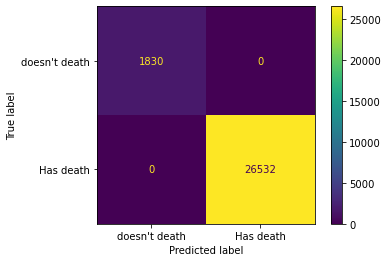

In [37]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["doesn't death", "Has death"])

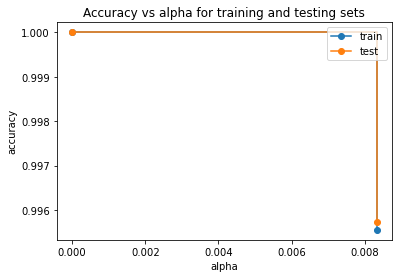

In [38]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas = ccp_alphas[:-1]

clf_dts = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts] # the accuracy of the classifications 
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

---------

## Do more modeling to get the most accurate one for the final prediction

In [45]:
from sklearn.metrics import accuracy_score

Model 1: Multinomial Naive Bayes Classifier

In [46]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print('naive bayes accuracy %s' % accuracy_score(y_pred, y_test))

naive bayes accuracy 0.7739933714124533


Model 2: Linear SVM

In [47]:
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train, y_train)
y_pred = lsvm.predict(X_test)
print('svm using accuracy %s' % accuracy_score(y_pred, y_test))

svm using accuracy 0.8800860306043298


Model 3: logistic regression

In [48]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('log reg accuracy %s' % accuracy_score(y_pred, y_test))

log reg accuracy 0.9341019674211973


Model 4: Random Forest Classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(n_estimators=500)
rf1.fit(X_train, y_train)
y_pred = rf1.predict(X_test)
print('random forest accuracy %s' % accuracy_score(y_pred, y_test))

random forest accuracy 0.9998942246668077
